# Time Series Anomaly Detection

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import env

The dataset for these exercises lives in the Codeup Data Science MySQL Server. The database name is curriculum_logs.
Hint: You will need to explore the database (yay SQL!)

1. Label students by the program they are in.

2. Is it possible to identify the user_id of a staff member?

3. Identify students who are accessing our curriculum pages beyond the end of their time at Codeup.

4. Identify students who present anomalous activity using the Bollinger Band method, but reduce K to 2.

5. Plot the access activity of these students.

BONUS: Can you identify users who are viewing both the web dev and data science curriculum?

### Acquire

In [2]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
query = '''
SELECT *
FROM logs
LEFT JOIN cohorts ON cohorts.id= logs.cohort_id
'''
df = pd.read_sql(query, url)
df.head(20)

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0
5,2018-01-26,09:56:41,javascript-i/loops,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0
6,2018-01-26,09:56:46,javascript-i/conditionals,3,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0
7,2018-01-26,09:56:48,javascript-i/functions,3,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0
8,2018-01-26,09:56:59,javascript-i/loops,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0
9,2018-01-26,09:58:26,javascript-i/functions,4,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0


In [3]:
df.shape

(900223, 15)

In [4]:
df.head(20)

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0
5,2018-01-26,09:56:41,javascript-i/loops,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0
6,2018-01-26,09:56:46,javascript-i/conditionals,3,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0
7,2018-01-26,09:56:48,javascript-i/functions,3,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0
8,2018-01-26,09:56:59,javascript-i/loops,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0
9,2018-01-26,09:58:26,javascript-i/functions,4,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0


In [5]:
df[df.cohort_id.isnull()]

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
411,2018-01-26,16:46:16,/,48,NaN,97.105.19.61,NaN,None,None,None,None,None,None,None,NaN
412,2018-01-26,16:46:24,spring/extra-features/form-validation,48,NaN,97.105.19.61,NaN,None,None,None,None,None,None,None,NaN
425,2018-01-26,17:54:24,/,48,NaN,97.105.19.61,NaN,None,None,None,None,None,None,None,NaN
435,2018-01-26,18:32:03,/,48,NaN,97.105.19.61,NaN,None,None,None,None,None,None,None,NaN
436,2018-01-26,18:32:17,mysql/relationships/joins,48,NaN,97.105.19.61,NaN,None,None,None,None,None,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899897,2021-04-21,12:49:00,javascript-ii,717,NaN,136.50.102.126,NaN,None,None,None,None,None,None,None,NaN
899898,2021-04-21,12:49:02,javascript-ii/es6,717,NaN,136.50.102.126,NaN,None,None,None,None,None,None,None,NaN
899899,2021-04-21,12:51:27,javascript-ii/map-filter-reduce,717,NaN,136.50.102.126,NaN,None,None,None,None,None,None,None,NaN
899900,2021-04-21,12:52:37,javascript-ii/promises,717,NaN,136.50.102.126,NaN,None,None,None,None,None,None,None,NaN


### Prepare

In [6]:
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)
pages = df['path'].resample('d').count()
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: path, dtype: int64

### Label Program Name

In [7]:
df.program_id.value_counts()

2.0    713365
3.0    103412
1.0     30548
4.0         5
Name: program_id, dtype: int64

In [8]:
df['program_name']= df.program_id

In [9]:
df.program_name = df.program_name.replace({1.0:'full_stack_php',2.0:'full_stack_java',3.0:'data_science',4.0:'front_end'})

In [10]:
df

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,program_name
date,,,,,,,,,,,,,,,,
2018-01-26,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,full_stack_php
2018-01-26,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,full_stack_php
2018-01-26,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,full_stack_php
2018-01-26,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,full_stack_php
2018-01-26,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0,full_stack_java
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21,2021-04-21,16:41:51,jquery/personal-site,64,28.0,71.150.217.33,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,full_stack_java
2021-04-21,2021-04-21,16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,full_stack_java
2021-04-21,2021-04-21,16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,full_stack_java


In [11]:
df.to_csv('curriculum_logs_edited', index=False)

### ID Staff Members

In [12]:
df[df.name =='Staff']

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,program_name
date,,,,,,,,,,,,,,,,
2018-12-06,2018-12-06,14:15:29,appendix/further-reading/java/intellij-tomcat-...,53,28.0,97.105.19.58,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,full_stack_java
2018-12-06,2018-12-06,14:25:40,javascript-i,314,28.0,97.105.19.58,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,full_stack_java
2018-12-06,2018-12-06,14:25:41,javascript-i/coffee-project,314,28.0,97.105.19.58,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,full_stack_java
2018-12-06,2018-12-06,15:31:29,spring,40,28.0,170.248.173.247,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,full_stack_java
2018-12-06,2018-12-06,15:31:33,spring/fundamentals/security,40,28.0,170.248.173.247,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,full_stack_java
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21,2021-04-21,16:41:51,jquery/personal-site,64,28.0,71.150.217.33,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,full_stack_java
2021-04-21,2021-04-21,16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,full_stack_java
2021-04-21,2021-04-21,16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,full_stack_java


### ID students accessing curriculumn pass the end date of program

In [13]:
students= df[df.name !='Staff']

In [14]:
peeking_after = students[students.end_date<students.index]
peeking_after

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,program_name
date,,,,,,,,,,,,,,,,
2018-01-26,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,full_stack_php
2018-01-26,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,full_stack_php
2018-01-26,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,full_stack_php
2018-01-26,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,full_stack_php
2018-01-26,2018-01-26,10:14:47,/,11,1.0,97.105.19.61,1.0,Arches,#arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,full_stack_php
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21,2021-04-21,15:20:12,classification/classical_programming_vs_machin...,692,59.0,96.8.130.134,59.0,Darden,#darden,2020-07-13,2021-01-12,2020-07-13 18:32:19,2020-07-13 18:32:19,None,3.0,data_science
2021-04-21,2021-04-21,15:20:12,classification/scale_features_or_not.svg,692,59.0,96.8.130.134,59.0,Darden,#darden,2020-07-13,2021-01-12,2020-07-13 18:32:19,2020-07-13 18:32:19,None,3.0,data_science
2021-04-21,2021-04-21,15:20:14,classification/project,692,59.0,96.8.130.134,59.0,Darden,#darden,2020-07-13,2021-01-12,2020-07-13 18:32:19,2020-07-13 18:32:19,None,3.0,data_science


### Use Bollinger Band method to ID students with anomalous activity. (set k=2)

In [15]:
def acquire_logs(user=env.user, password=env.password, host=env.host):
    '''
    This function queries the Codeup MySQL curriculum_logs database and returns a dataframe
    '''
    url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
    query = '''
    SELECT date,
           path ,
           user_id,
           cohort_id,
           ip as source_ip
    FROM logs;
    '''
    df = pd.read_sql(query, url)
    return df

In [16]:
def one_user_df_prep(df, user):
    '''
    This function returns a dataframe consisting of data for only a single defined user
    '''
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    pages_one_user = df['path'].resample('d').count()
    return pages_one_user

In [17]:
def compute_pct_b(pages_one_user, span, weight, user):
    '''
    This function adds the %b of a bollinger band range for the page views of a single user's log activity
    '''
    # Calculate upper and lower bollinger band
    midband = pages_one_user.ewm(span=span).mean()
    stdev = pages_one_user.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    
    # Add upper and lower band values to dataframe
    bb = pd.concat([ub, lb], axis=1)
    
    # Combine all data into a single dataframe
    my_df = pd.concat([pages_one_user, midband, bb], axis=1)
    my_df.columns = ['pages_one_user', 'midband', 'ub', 'lb']
    
    # Calculate percent b and relevant user id to dataframe
    my_df['pct_b'] = (my_df['pages_one_user'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

In [18]:
def plot_bands(my_df, user):
    '''
    This function plots the bolliger bands of the page views for a single user
    '''
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages_one_user, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()

In [19]:
def find_anomalies(df, user, span, weight, plot=False):
    '''
    This function returns the records where a user's daily activity exceeded the upper limit of a bollinger band range
    '''
    
    # Reduce dataframe to represent a single user
    pages_one_user = one_user_df_prep(df, user)
    
    # Add bollinger band data to dataframe
    my_df = compute_pct_b(pages_one_user, span, weight, user)
    
    # Plot data if requested (plot=True)
    if plot:
        plot_bands(my_df, user)
    
    # Return only records that sit outside of bollinger band upper limit
    return my_df[my_df.pct_b>1]

In [20]:
span = 30
weight = 2

anomalies = pd.DataFrame()
for u in list(students.user_id.unique()):
    user_df = find_anomalies(students, u, span, weight)
    anomalies = pd.concat([anomalies, user_df], axis=0)

In [21]:
anomalies

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,
2018-02-20,54,6.456745,35.718248,-22.804758,1.312386,1
2018-03-19,35,9.304089,32.368632,-13.760453,1.057044,1
2018-05-04,27,7.179313,24.736171,-10.377545,1.064471,1
2018-05-11,27,8.141119,26.687629,-10.405390,1.008421,1
2018-05-29,68,9.612443,44.787234,-25.562347,1.329963,1
...,...,...,...,...,...,...
2021-03-25,16,4.929382,15.757106,-5.898343,1.011216,948
2021-03-29,28,6.004114,24.426496,-12.418268,1.096988,948
2021-04-17,25,8.260254,23.336345,-6.815837,1.055175,948


In [22]:
anomalies.user_id.value_counts()

186    44
127    32
120    31
48     30
79     30
       ..
734     1
402     1
401     1
726     1
949     1
Name: user_id, Length: 803, dtype: int64

### Plot Users

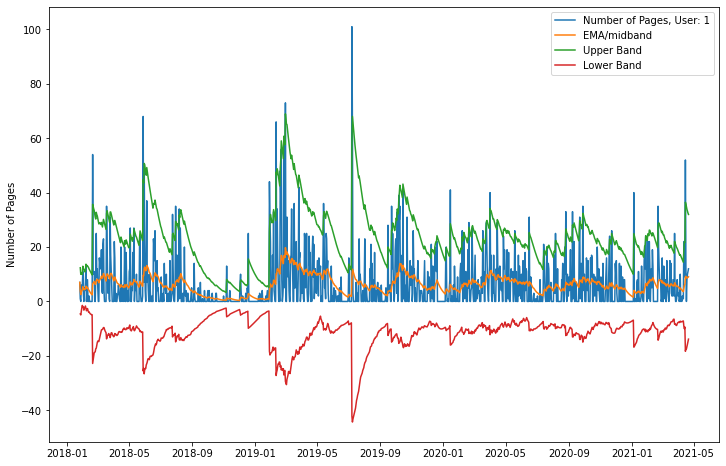

In [23]:
user = 1
span = 30
weight = 2
user_df = find_anomalies(df, user, span, weight, plot=True)

anomalies = pd.DataFrame()
user_df = find_anomalies(df, user, span, weight)
anomalies = pd.concat([anomalies, user_df], axis=0)

## At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?


In [24]:
# making a copy of the data without staff
df = students.copy()

In [25]:
# renaming path to endpoint
df = df.rename(columns = {"path":"endpoint"})

In [26]:
df.head()

,date,time,endpoint,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,program_name
date,,,,,,,,,,,,,,,,
2018-01-26,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,full_stack_php
2018-01-26,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,full_stack_php
2018-01-26,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,full_stack_php
2018-01-26,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,full_stack_php
2018-01-26,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0,full_stack_java


In [27]:
# zeroing in on 2019
yr_2019=df[df['date'].dt.year == 2019]


In [28]:
yr_2019.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 224620 entries, 2019-01-01 to 2019-12-31
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          224620 non-null  datetime64[ns]
 1   time          224620 non-null  object        
 2   endpoint      224620 non-null  object        
 3   user_id       224620 non-null  int64         
 4   cohort_id     201759 non-null  float64       
 5   ip            224620 non-null  object        
 6   id            201759 non-null  float64       
 7   name          201759 non-null  object        
 8   slack         201759 non-null  object        
 9   start_date    201759 non-null  object        
 10  end_date      201759 non-null  object        
 11  created_at    201759 non-null  object        
 12  updated_at    201759 non-null  object        
 13  deleted_at    0 non-null       object        
 14  program_id    201759 non-null  float64       
 15  p

<AxesSubplot:>

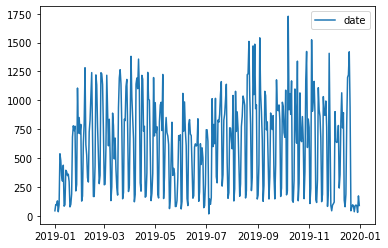

In [29]:
# looks like there was a dip between June and July in 2019

viz_line=pd.DataFrame(yr_2019.date.value_counts()).sort_index()
sns.lineplot(data=viz_line)

In [30]:
df.program_name.value_counts()

full_stack_java    629334
data_science       103412
full_stack_php      30548
front_end               5
Name: program_name, dtype: int64

In [31]:
# plan: make dataframes for only DS students and only WD students,
# determine which pages are unique to webdev and which are unique to ds
#See if there is a drop in accesses in 2019

In [32]:

ds_df = df[(df.program_name == 'data_science')]
#ds_df = ds_df.drop(columns=['date'])

df.program_name = df.program_name.replace({'full_stack_php':'web_dev','full_stack_java':'web_dev','front_end': 'web_dev'})

wd_df = df[(df.program_name == 'web_dev')]
#wd_df = wd_df.drop(columns = ['date'])

In [33]:
yr_2019.shape

(224620, 16)

In [34]:
df.shape

# 2019 represents approximately 1/4 of the total data

(816192, 16)

In [35]:
# total endpoint pages for the year 2019: 1350
yr_2019.endpoint.value_counts()

/                           11401
search/search_index.json     5694
toc                          4770
javascript-i                 4421
html-css                     3351
                            ...  
students/743/notes              1
8_Prophet_Lesson                1
Lesson_Modeling                 1
tools                           1
mysql//extra-exercises          1
Name: endpoint, Length: 1350, dtype: int64

In [36]:
#data science endpoint pages: 682
ds_df.endpoint.value_counts()

/                                           8358
search/search_index.json                    2203
classification/overview                     1785
1-fundamentals/modern-data-scientist.jpg    1655
1-fundamentals/AI-ML-DL-timeline.jpg        1651
                                            ... 
python/custom-sorting-functions                1
imports                                        1
java-i/console-io                              1
appendix/univariate_regression_in_excel        1
6-regression/8-Project                         1
Name: endpoint, Length: 682, dtype: int64

In [37]:
# web development endpoint pages: 1289
wd_df.endpoint.value_counts()

/                               31156
toc                             16669
javascript-i                    16376
search/search_index.json        13982
html-css                        11827
                                ...  
objects/math                        1
12.3.6_Page_Styling                 1
slides/threads                      1
slides/coding_best_practices        1
cohorts/24/grades                   1
Name: endpoint, Length: 1289, dtype: int64

Initial thoughts are that either there are way more web pages that are unique to web development than data science, or that web dev students had access to data science pages

In [38]:
viz_ds = pd.DataFrame(ds_df.date.value_counts()).sort_index()
viz_wd = pd.DataFrame(wd_df.date.value_counts()).sort_index()

<AxesSubplot:>

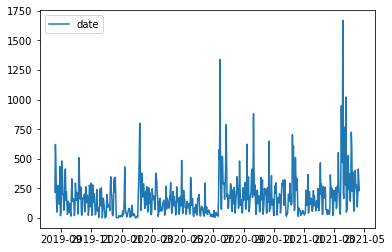

In [39]:
sns.lineplot(data = viz_ds)

<AxesSubplot:>

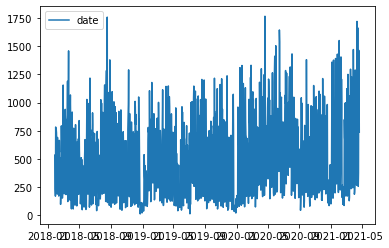

In [40]:
sns.lineplot(data= viz_wd)

In [41]:
# unique pages visited 
ds_page= list(ds_df.endpoint.unique())

# list of unique pages in web dev
web_page= list(wd_df.endpoint.unique())

# create a loop to cross check a page visited by ds students that matches with unique pages from web dev program

count= 0
for x in web_page:
    if x in ds_page:
        
        count+= 1       
print(count)

127


The above result shows that there is cross-curriculum page visits

In [42]:
# Focusing on the month of June where there seems to be the lowest dip
June_2019=yr_2019[yr_2019['date'].dt.month == 6]
# df for data science of June 2019
ds_June = June_2019[(June_2019.program_name == 'data_science')]
# df for web development of June 2019
wd_June = June_2019[(June_2019.program_name == "web_dev")]

In [43]:
# checking for cross-curriculum page endpoints for June: there are none
ds_June_page = list(ds_June.endpoint.unique())

web_June_page = list(wd_June.endpoint.unique())

count = 0
for x in ds_June_page:
    if x in web_June_page:
        count += 1
        
print(count)

0


In [44]:
# Focusing on the month of May
May_2019=yr_2019[yr_2019['date'].dt.month == 5]
# df for data science of June 2019
ds_May = May_2019[(May_2019.program_name == 'data_science')]
# df for web development of June 2019
wd_May = May_2019[(May_2019.program_name == "web_dev")]

In [45]:
# checking for cross-curriculum page endpoints for June: there are none
ds_May_page = list(ds_May.endpoint.unique())

web_May_page = list(wd_May.endpoint.unique())

count = 0
for x in ds_May_page:
    if x in web_May_page:
        count += 1
        
print(count)

0


I ran this loop through all months before June and they all came back with zero. This implies that 2019 began with no cross-curriculum page checking. 

In [46]:
# Focusing on the month of May
Dec_2019=yr_2019[yr_2019['date'].dt.month == 12]

# df for data science of June 2019
ds_Dec = Dec_2019[(Dec_2019.program_name == 'data_science')]

# df for web development of June 2019
wd_Dec = Dec_2019[(Dec_2019.program_name == "web_dev")]

In [47]:
# checking for cross-curriculum page endpoints for June: there are none
ds_Dec_page = list(ds_Dec.endpoint.unique())

web_Dec_page = list(wd_Dec.endpoint.unique())

count = 0
for x in ds_Dec_page:
    if x in web_Dec_page:
        count += 1
        
print(count)

0


July: 0
August: 19
September: 44
October: 26
November: 26
December: 41

# Takeaway:
* The data shows that 2019 with students not being able to access pages in the curriculum outside of their course
* Students were able to access corss-curriculum pages begining in August and for the rest of the year